# Simulated Dataset of 1000 Individuals

In [1]:
from src.utils import *
from src.dgp import dgp_rnd_assignment

df = dgp_rnd_assignment().generate_data()
df.head()

,Group,Arm,Gender,Age,Income
0,control,NaN,0,29.0,568.44
1,control,NaN,1,32.0,596.45
2,treatment,arm 3,0,29.0,380.86
3,control,NaN,0,25.0,476.38
4,treatment,arm 4,1,32.0,628.28


Treated individuals are distributed across four treatment arms.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Group   1000 non-null   object 
 1   Arm     296 non-null    object 
 2   Gender  1000 non-null   int32  
 3   Age     1000 non-null   float64
 4   Income  1000 non-null   float64
dtypes: float64(2), int32(1), object(2)
memory usage: 35.3+ KB


# Two Groups - Plots

### 1. Boxplot

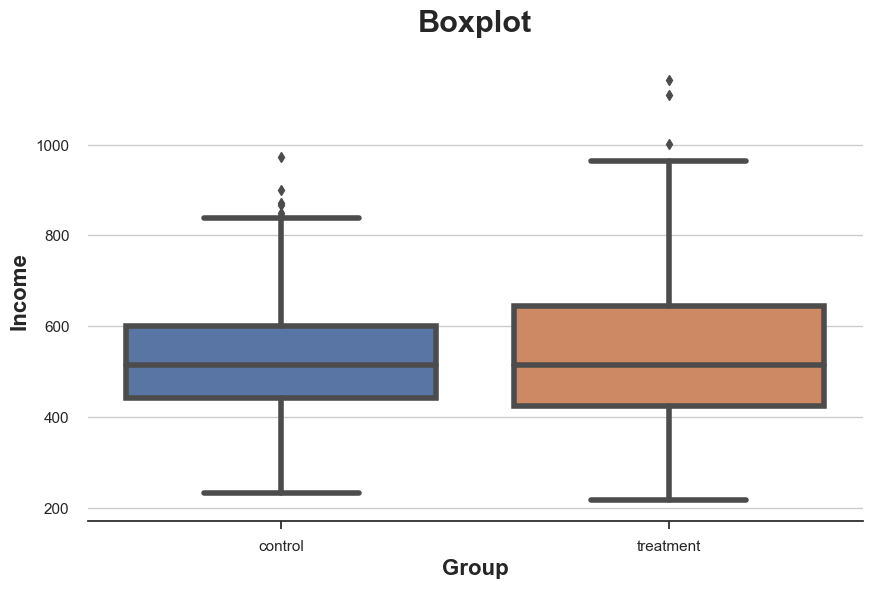

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df, x='Group', y='Income');
plt.title("Boxplot");

### 2. Histogram

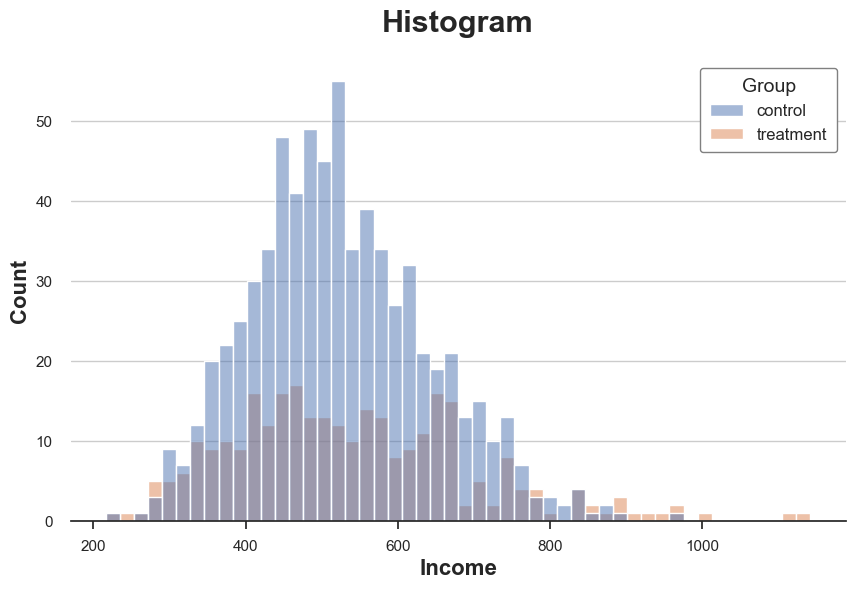

In [4]:
sns.histplot(data=df, x='Income', hue='Group', bins=50);
plt.title("Histogram");

There are multiple issues with this plot:

- Since the two groups have a different number of observations, the two histograms are not comparable
- The number of bins is arbitrary

We can solve the first issue using the `stat` option to plot the `density` instead of the `count` and setting the `common_norm` option to `False` to normalize each histogram separately.

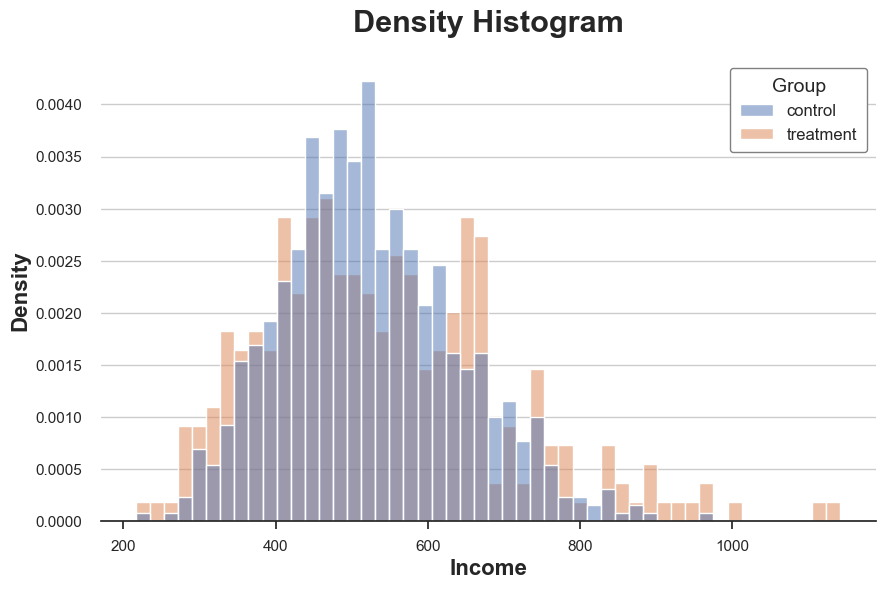

In [5]:
sns.histplot(data=df, x='Income', hue='Group', bins=50, stat='density', common_norm=False);
plt.title("Density Histogram");

However, an important issue remains: the size of the bins is arbitrary. In the extreme, if we bunch the data less, we end up with bins with at most one observation, if we bunch the data more, we end up with a single bin. In both cases, if we exaggerate, the plot loses informativeness. This is a classical bias-variance trade-off.

### 3. Kernel Density

One possible solution is to use a kernel density function that tries to approximate the histogram with a continuous function, using kernel density estimation (KDE).

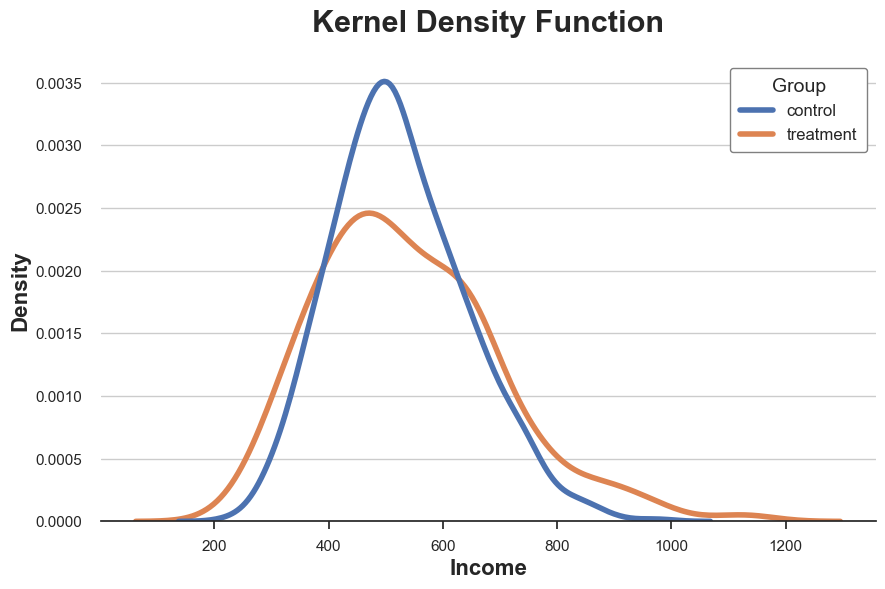

In [6]:
sns.kdeplot(x='Income', data=df, hue='Group', common_norm=False);
plt.title("Kernel Density Function");

The issue with kernel density estimation is that it is a bit of a black box and might mask relevant features of the data.

### 4. Cumulative Distribution

A more transparent representation of the two distributions is their cumulative distribution function.
- we do not need to make any arbitrary choice (e.g. number of bins)
- we do not need to perform any approximation (e.g. with KDE), but we represent all data points

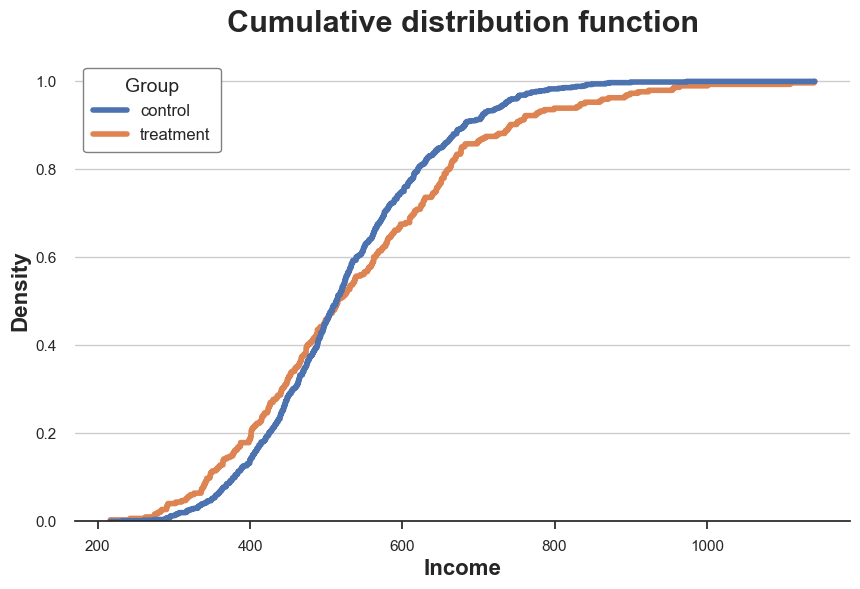

In [7]:
sns.histplot(x='Income', data=df, hue='Group', bins=len(df), stat="density",
             element="step", fill=False, cumulative=True, common_norm=False);
plt.title("Cumulative distribution function");

- Since the two lines cross more or less at 0.5 (y axis), it means that their median is similar
- Since the orange line is above the blue line on the left and below the blue line on the right, it means that the distribution of the treatment group as fatter tails

### 5. Q-Q Plot

A related method is the Q-Q plot, where q stands for quantile. The Q-Q plot plots the quantiles of the two distributions against each other. If the distributions are the same, we should get a 45-degree line.

In [8]:
income = df['Income'].values
income_t = df.loc[df.Group=='treatment', 'Income'].values
income_c = df.loc[df.Group=='control', 'Income'].values

df_pct = pd.DataFrame()
df_pct['q_treatment'] = np.percentile(a=income_t, q=range(100))  # q=range(100) mean percentiles from 0 to 100
df_pct['q_control'] = np.percentile(a=income_c, q=range(100))

In [9]:
df_pct

,q_treatment,q_control
0,216.3600,232.2600
1,273.8305,295.5619
2,282.2830,315.5658
3,291.1895,331.6823
4,301.1760,340.2596
...,...,...
95,836.4875,735.6905
96,864.0700,743.5344
97,895.7250,761.0503
98,927.0380,787.3636


Now we can plot the two quantile distributions against each other, plus the 45-degree line, representing the benchmark perfect fit.

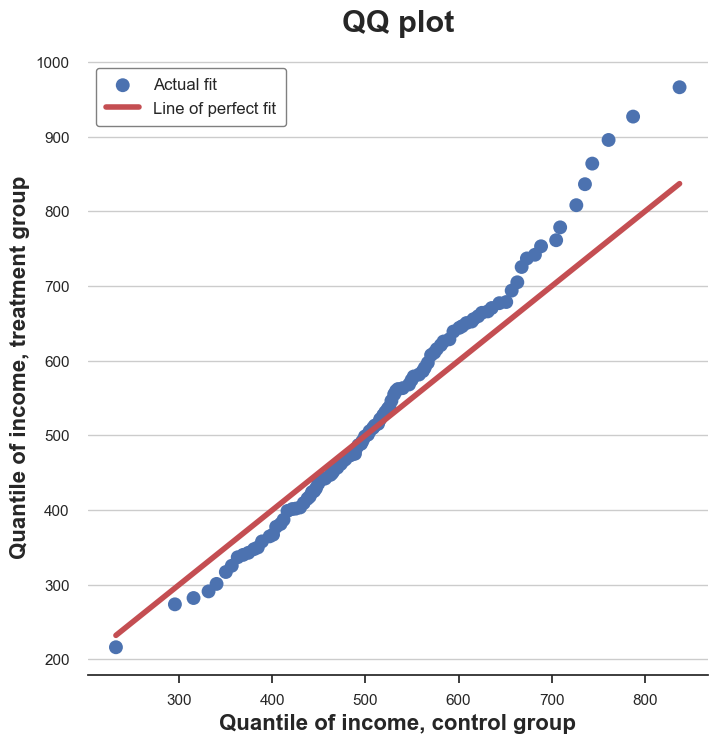

In [10]:
plt.figure(figsize=(8, 8))
plt.scatter(x='q_control', y='q_treatment', data=df_pct, label='Actual fit')
sns.lineplot(x='q_control', y='q_control', data=df_pct, color='r', label='Line of perfect fit')  # for 45 degree line
plt.xlabel('Quantile of income, control group')
plt.ylabel('Quantile of income, treatment group')
plt.legend()
plt.title("QQ plot");

The Q-Q plot delivers a very similar insight with respect to the cumulative distribution plot: income in the treatment group has the same median (lines cross in the center) but wider tails (dots are below the line on the left end and above on the right end).

# Two Groups - Statistical Tests

### 1. T-test

The first and most common test is the student t-test. T-tests are generally used to compare means. In this case, we want to test whether the means of the income distribution are the same across the two groups.

We use the `ttest_ind` function from `scipy` to perform the t-test. The function returns both the test statistic and the implied p-value.

In [11]:
from scipy.stats import ttest_ind

stat, p_value = ttest_ind(income_c, income_t)
print(f"t-test: statistic={stat:.4f}, p-value={p_value:.4f}")

t-test: statistic=-1.5549, p-value=0.1203


The p-value of the test is 0.12, therefore we do not reject the null hypothesis of no difference in means across treatment and control groups.

> Note: the t-test assumes that the variance in the two samples is the same so that its estimate is computed on the joint sample. Welch’s t-test allows for unequal variances in the two samples.

### 2. Standardized Mean Difference (SMD)

Since the denominator of the t-test statistic depends on the sample size, the t-test has been criticized for making p-values hard to compare across studies. In fact, we may obtain a significant result in an experiment with a very small magnitude of difference but a large sample size while we may obtain a non-significant result in an experiment with a large magnitude of difference but a small sample size.

One solution that has been proposed is the standardized mean difference (SMD). As the name suggests, this is not a proper test statistic, but just a standardized difference.

Usually, a value below 0.1 is considered a “small” difference.

It is good practice to collect average values of all variables across treatment and control groups and a measure of distance between the two — either the t-test or the SMD — into a table that is called balance table. We can use the `create_table_one` function from the `causalml` library to generate it. As the name of the function suggests, the balance table should always be the first table you present when performing an A/B test.

In [12]:
from causalml.match import create_table_one

df['treatment'] = df['Group']=='treatment'
create_table_one(df, 'treatment', ['Gender', 'Age', 'Income'])

,Control,Treatment,SMD
Variable,,,
n,704,296,
Age,32.40 (8.54),36.42 (7.76),0.4928
Gender,0.51 (0.50),0.58 (0.49),0.1419
Income,524.59 (117.35),538.75 (160.15),0.1009


In the first two columns, we can see the average of the different variables across the treatment and control groups, with standard errors in parenthesis. In the last column, the values of the SMD indicate a standardized difference of more than 0.1 for all variables, suggesting that the two groups are probably different.

### 3. Mann–Whitney U Test

Different from the other tests we have seen so far, the Mann–Whitney U test is agnostic to outliers and concentrates on the center of the distribution.

The test procedure is the following.

1. Combine all data points and rank them (in increasing or decreasing order)
2. Compute $U₁ = R₁ − n₁(n₁ + 1)/2$, where $R₁$ is the sum of the ranks for data points in the first group and $n₁$ is the number of points in the first group.
3. Compute $U₂$ similarly for the second group.
4. The test statistic is given by $stat = min(U₁, U₂)$.

Under the null hypothesis of no systematic rank differences between the two distributions (i.e. same median), the test statistic is asymptotically normally distributed with known mean and variance.

The intuition behind the computation of $R$ and $U$ is the following: if the values in the first sample were all bigger than the values in the second sample, then $R₁ = n₁(n₁ + 1)/2$ and, as a consequence, $U₁$ would then be zero (minimum attainable value). Otherwise, if the two samples were similar, $U₁$ and $U₂$ would be very close to $n₁ n₂ / 2$ (maximum attainable value).

In [13]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(income_t, income_c)
print(f" Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")

 Mann–Whitney U Test: statistic=106371.5000, p-value=0.6012


We get a p-value of 0.6 which implies that we do not reject the null hypothesis that the distribution of `income` is the same in the treatment and control groups

> Note: as for the t-test, there exists a version of the Mann–Whitney U test for unequal variances in the two samples, the Brunner-Munzel test.

### 4. Permutation Test

A non-parametric alternative is permutation testing. The idea is that, under the null hypothesis, the two distributions should be the same, therefore shuffling the `group` labels should not significantly alter any statistic.

We can choose any statistic and check how its value in the original sample compares with its distribution across group label permutations. For example, let's use as a test statistic the difference in sample means between the treatment and control groups.

In [14]:
sample_stat = np.mean(income_t) - np.mean(income_c)
stats = np.zeros(1000)
for k in range(1000):
    labels = np.random.permutation((df['Group'] == 'treatment').values)
    stats[k] = np.mean(income[labels]) - np.mean(income[labels==False])
p_value = np.mean(stats > sample_stat)

print(f"Permutation test: p-value={p_value:.4f}")

Permutation test: p-value=0.0530


The permutation test gives us a p-value of 0.053, implying a weak non-rejection of the null hypothesis at the 5% level.

How do we interpret the p-value? It means that the difference in means in the data is larger than 1–0.0560 = 94.4% of the differences in means across the permuted samples.

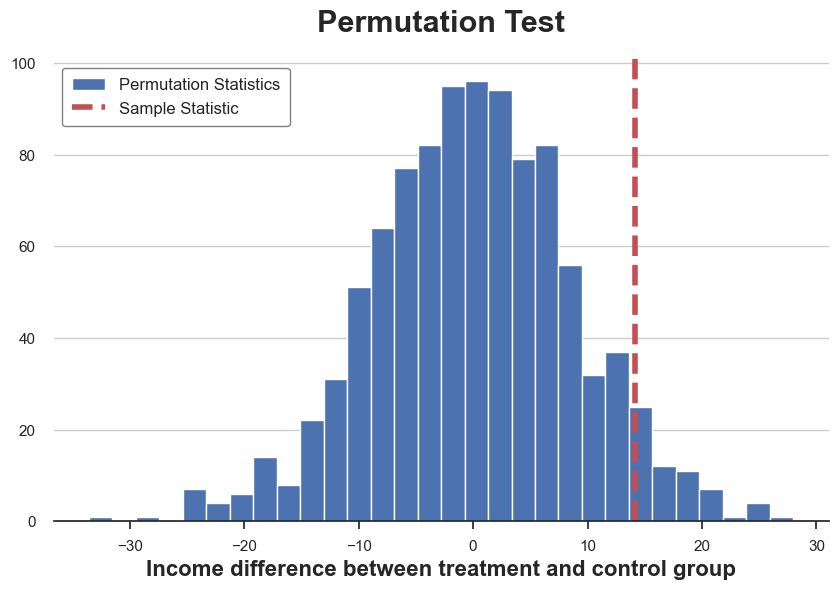

In [15]:
plt.hist(stats, label='Permutation Statistics', bins=30);
plt.axvline(x=sample_stat, c='r', ls='--', label='Sample Statistic');
plt.legend();
plt.xlabel('Income difference between treatment and control group')
plt.title('Permutation Test');

As we can see, the sample statistic is quite extreme with respect to the values in the permuted samples, but not excessively.

### 5. Chi-Squared Test

The chi-squared test is a very powerful test that is mostly used to test differences in frequencies.

One of the least known applications of the chi-squared test is testing the similarity between two distributions. The idea is to bin the observations of the two groups. If the two distributions were the same, we would expect the same frequency of observations in each bin. Importantly, we need enough observations in each bin, in order for the test to be valid.

I generate bins corresponding to deciles of the distribution of income in the control group and then I compute the expected number of observations in each bin in the treatment group if the two distributions were the same.

In [16]:
# Init dataframe
df_bins = pd.DataFrame()

# Generate bins from control group
_, bins = pd.qcut(income_c, q=10, retbins=True)
df_bins['bin'] = pd.cut(income_c, bins=bins).value_counts().index

# Apply bins to both groups
df_bins['income_c_observed'] = pd.cut(income_c, bins=bins).value_counts().values
df_bins['income_t_observed'] = pd.cut(income_t, bins=bins).value_counts().values

# Compute expected frequency in the treatment group
df_bins['income_t_expected'] = df_bins['income_c_observed'] / np.sum(df_bins['income_c_observed']) * np.sum(df_bins['income_t_observed'])

df_bins

,bin,income_c_observed,income_t_observed,income_t_expected
0,"(232.26, 380.496]",70,46,29.075391
1,"(380.496, 425.324]",70,30,29.075391
2,"(425.324, 456.795]",70,24,29.075391
3,"(456.795, 488.83]",71,26,29.490754
4,"(488.83, 513.66]",70,18,29.075391
5,"(513.66, 540.048]",70,19,29.075391
6,"(540.048, 576.664]",71,21,29.490754
7,"(576.664, 621.022]",70,25,29.075391
8,"(621.022, 682.003]",70,42,29.075391
9,"(682.003, 973.46]",71,41,29.490754


We can now perform the test by comparing the expected (E) and observed (O) number of observations in the treatment group, across bins.

Since we generated the bins using deciles of the distribution of income in the control group, we expect the number of observations per bin in the treatment group to be the same across bins. The test statistic is asymptotically distributed as a chi-squared distribution.

To compute the test statistic and the p-value of the test, we use the `chisquare` function from `scipy`.

In [17]:
from scipy.stats import chisquare

stat, p_value = chisquare(df_bins['income_t_observed'], df_bins['income_t_expected'])
print(f"Chi-squared Test: statistic={stat:.4f}, p-value={p_value:.4f}")

Chi-squared Test: statistic=32.1432, p-value=0.0002


Differently from all other tests so far, the chi-squared test strongly rejects the null hypothesis that the two distributions are the same. Why?

The reason lies in the fact that the two distributions have a similar center but different tails and the chi-squared test tests the similarity along the whole distribution and not only in the center, as we were doing with the previous tests.

This result tells a cautionary tale: it is very important to understand what you are actually testing before drawing blind conclusions from a p-value!

### 6. Kolmogorov-Smirnov Test

The Kolmogorov-Smirnov test is probably the most popular non-parametric test to compare distributions. The idea of the Kolmogorov-Smirnov test is to compare the cumulative distributions of the two groups. In particular, the Kolmogorov-Smirnov test statistic is the maximum absolute difference between the two cumulative distributions.

The asymptotic distribution of the Kolmogorov-Smirnov test statistic is Kolmogorov distributed.

To better understand the test, let’s plot the cumulative distribution functions and the test statistic. First, we compute the cumulative distribution functions.

In [18]:
df_ks = pd.DataFrame()
df_ks['Income'] = np.sort(df['Income'].unique())
df_ks['F_control'] = df_ks['Income'].apply(lambda x: np.mean(income_c<=x))
df_ks['F_treatment'] = df_ks['Income'].apply(lambda x: np.mean(income_t<=x))
df_ks.head()

,Income,F_control,F_treatment
0,216.36,0.000000,0.003378
1,232.26,0.001420,0.003378
2,243.15,0.001420,0.006757
3,259.88,0.002841,0.006757
4,262.82,0.002841,0.010135


We now need to find the point where the absolute distance between the cumulative distribution functions is largest.

In [19]:
k = np.argmax(np.abs(df_ks['F_control'] - df_ks['F_treatment']))
ks_stat = np.abs(df_ks['F_treatment'][k] - df_ks['F_control'][k])

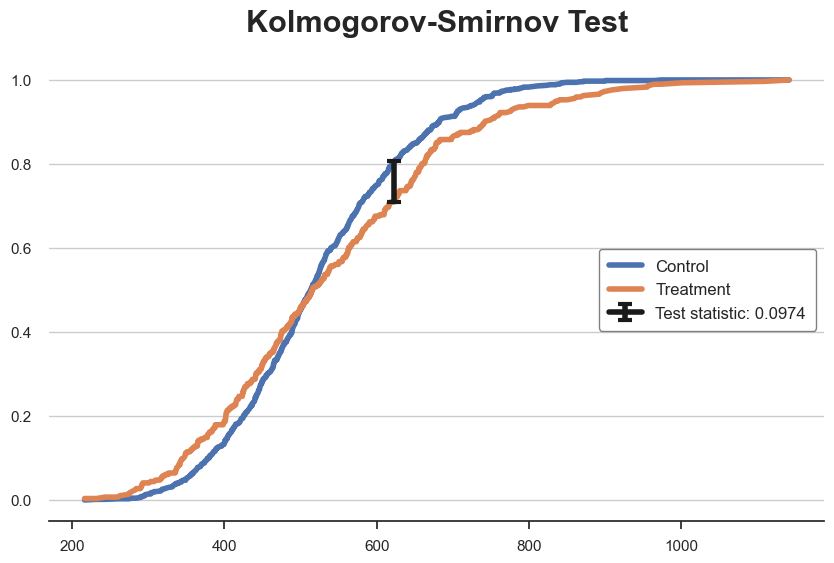

In [20]:
y = (df_ks['F_treatment'][k] + df_ks['F_control'][k])/2
plt.plot('Income', 'F_control', data=df_ks, label='Control')
plt.plot('Income', 'F_treatment', data=df_ks, label='Treatment')
plt.errorbar(x=df_ks['Income'][k], y=y, yerr=ks_stat/2, color='k',
             capsize=5, mew=3, label=f"Test statistic: {ks_stat:.4f}")
plt.legend(loc='center right');
plt.title("Kolmogorov-Smirnov Test");

From the plot, we can see that the value of the test statistic corresponds to the distance between the two cumulative distributions at `income`~650. For that value of `income`, we have the largest imbalance between the two groups.

We can now perform the actual test using the `kstest` function from `scipy`.

In [21]:
from scipy.stats import kstest

stat, p_value = kstest(income_t, income_c)
print(f" Kolmogorov-Smirnov Test: statistic={stat:.4f}, p-value={p_value:.4f}")

 Kolmogorov-Smirnov Test: statistic=0.0974, p-value=0.0355


The p-value is below 5%: we reject the null hypothesis that the two distributions are the same, with 95% confidence.

> Note 1: The KS test is too conservative and rejects the null hypothesis too rarely. Lilliefors test corrects this bias using a different distribution for the test statistic, the Lilliefors distribution.

> Note 2: the KS test uses very little information since it only compares the two cumulative distributions at one point: the one of maximum distance. The Anderson-Darling test and the Cramér-von Mises test instead compare the two distributions along the whole domain, by integration (the difference between the two lies in the weighting of the squared distances).

# Multiple Groups - Plots

As a working example, we are now going to check whether the distribution of `income` is the same across treatment `arms`.

### 1. Boxplot

The boxplot scales very well when we have a number of groups in the single-digits since we can put the different boxes side-by-side.

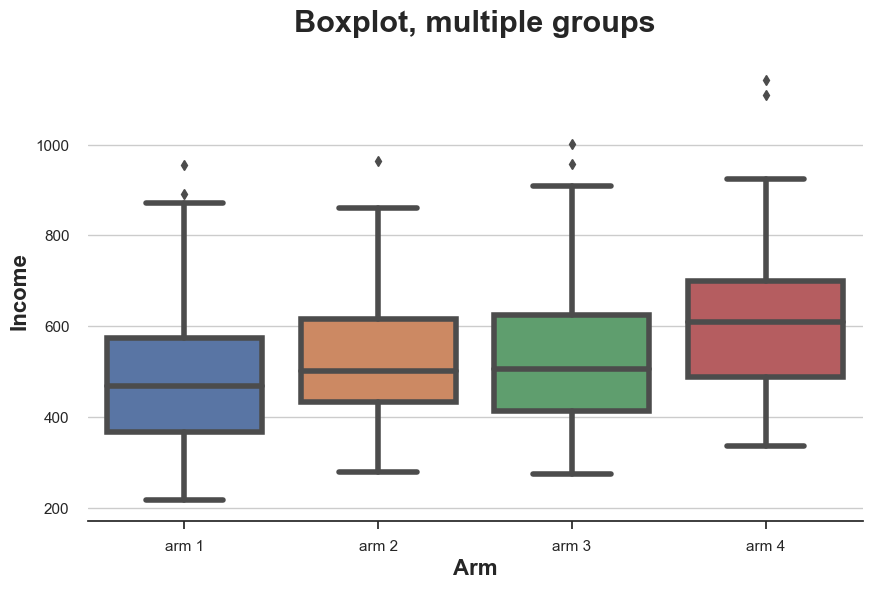

In [22]:
sns.boxplot(x='Arm', y='Income', data=df.sort_values('Arm'));
plt.title("Boxplot, multiple groups");

From the plot, it looks like the distribution of income is different across treatment arms, with higher numbered arms having a higher average income.

### 2. Violin Plot

A very nice extension of the boxplot that combines summary statistics and kernel density estimation is the violin plot. The violin plot displays separate densities along the y axis so that they don’t overlap. By default, it also adds a miniature boxplot inside.

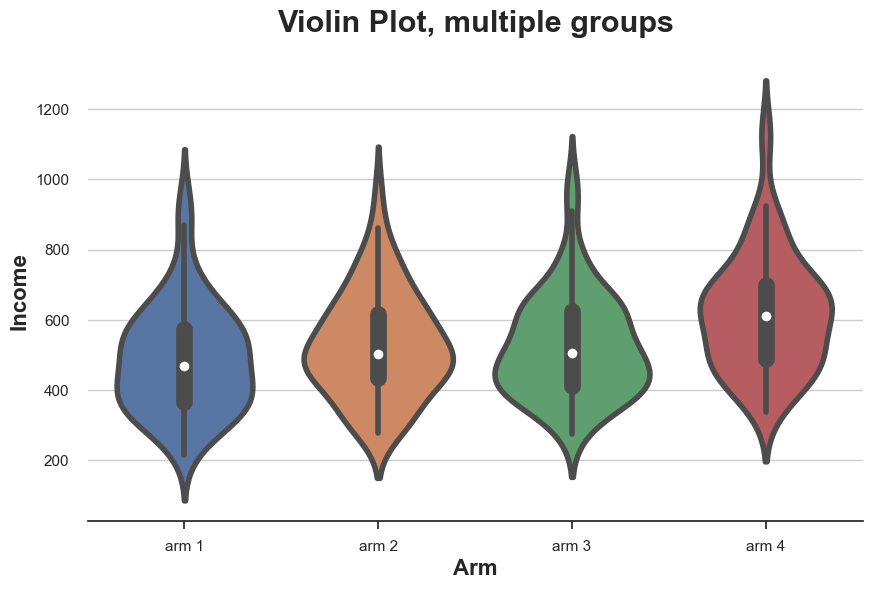

In [23]:
sns.violinplot(x='Arm', y='Income', data=df.sort_values('Arm'));
plt.title("Violin Plot, multiple groups");

As for the boxplot, the violin plot suggests that income is different across treatment arms.

### 3. Ridgeline Plot

Lastly, the ridgeline plot plots multiple kernel density distributions along the x-axis, making them more intuitive than the violin plot but partially overlapping them. Unfortunately, there is no default ridgeline plot neither in `matplotlib` nor in `seaborn`. We need to import it from `joypy`.

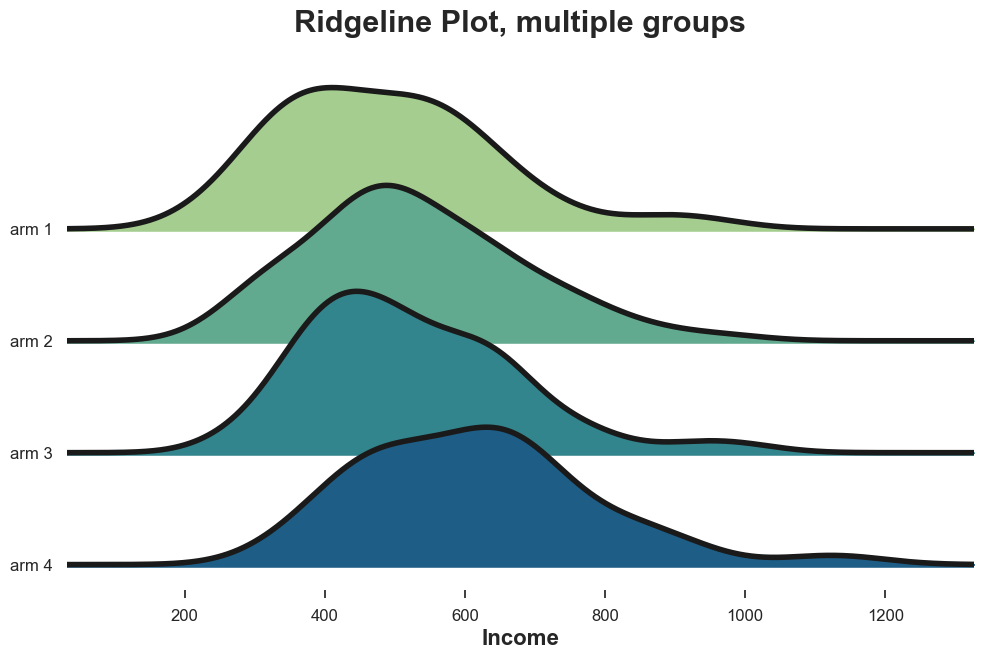

In [24]:
from joypy import joyplot

joyplot(df, by='Arm', column='Income', colormap=sns.color_palette("crest", as_cmap=True));
plt.xlabel('Income');
plt.title("Ridgeline Plot, multiple groups");

Again, the ridgeline plot suggests that higher numbered treatment arms have higher income. From this plot, it is also easier to appreciate the different shapes of the distributions.

# Multiple Groups - Tests

Lastly, let’s consider hypothesis tests to compare multiple groups. For simplicity, we will concentrate on the most popular one: the F-test.

### 1. F-test (a.k.a ANOVA)

With multiple groups, the most popular test is the F-test. The F-test compares the variance of a variable across different groups. This analysis is also called analysis of variance, or ANOVA.

Under the null hypothesis of group independence, the f-statistic is F-distributed.

In [25]:
from scipy.stats import f_oneway

income_groups = [df.loc[df['Arm']==arm, 'Income'].values for arm in df['Arm'].dropna().unique()]
stat, p_value = f_oneway(*income_groups)
print(f"F Test: statistic={stat:.4f}, p-value={p_value:.4f}")

F Test: statistic=9.0911, p-value=0.0000


The test p-value is basically zero, implying a strong rejection of the null hypothesis of no differences in the income distribution across treatment arms.

# Conclusion

We have seen how different methods might be better suited for different situations. Visual methods are great to build intuition, but statistical methods are essential for decision-making since we need to be able to assess the magnitude and statistical significance of the differences.